In [43]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorbayes.layers import constant as Constant 
from tensorbayes.layers import placeholder as Placeholder
from tensorbayes.layers import dense as Dense
from tensorbayes.layers import conv2d as Conv2d
from tensorbayes.layers import max_pool as Max_pool
from tensorbayes.layers import gaussian_sample as GaussianSample
from tensorbayes.distributions import log_bernoulli_with_logits, log_normal
from tensorbayes.tbutils import softmax_cross_entropy_with_two_logits as cross_entropy_with_logits
from tensorbayes.nbutils import show_graph
from tensorbayes.utils import progbar
import numpy as np
import sys
from shared_subgraphs import qy_graph, qz_graph, labeled_loss
from utils import train
print('completed')

completed


In [44]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## M2 Model

We can train Kingma's original M2 model in an unsupervised fashion.

In [45]:
def px_graph(z, y):
    reuse = len(tf.get_collection(tf.GraphKeys.VARIABLES, scope='px')) > 0
    # -- p(x)
    with tf.variable_scope('px'):
        zy = tf.concat((z, y),1, name='zy/concat')
        h1 = Dense(zy, 512, 'layer1', tf.nn.relu, reuse=reuse)
        h2 = Dense(h1, 512, 'layer2', tf.nn.relu, reuse=reuse)
        px_logit = Dense(h2, 784, 'logit', reuse=reuse)
    return px_logit

In [46]:
tf.reset_default_graph()
# print(Placeholder)
x = Placeholder((None, 784), name = 'x')

# binarize data and create a y "placeholder"
with tf.name_scope('x_binarized'):
    xb = tf.cast(tf.greater(x, tf.random_uniform(tf.shape(x), 0, 1)), tf.float32)
with tf.name_scope('y_'):
    y_ = tf.fill(tf.stack([tf.shape(x)[0], 10]), 0.0)

# propose distribution over y    
qy_logit, qy = qy_graph(xb)

# for each proposed y, infer z and reconstruct x
z, zm, zv, px_logit = [[None] * 10 for i in xrange(4)]
for i in xrange(10):
    with tf.name_scope('graphs/hot_at{:d}'.format(i)):
        y = tf.add(y_, Constant(np.eye(10)[i], name='hot_at_{:d}'.format(i)))
        z[i], zm[i], zv[i] = qz_graph(xb, y)
        px_logit[i] = px_graph(z[i], y)

# Aggressive name scoping for pretty graph visualization :P
with tf.name_scope('loss'):
    with tf.name_scope('neg_entropy'):
        nent = -cross_entropy_with_logits(qy_logit, qy)
    losses = [None] * 10
    for i in xrange(10):
        with tf.name_scope('loss_at{:d}'.format(i)):
            losses[i] = labeled_loss(xb, px_logit[i], z[i], zm[i], zv[i], Constant(0), Constant(1))
    with tf.name_scope('final_loss'):
        loss = tf.add_n([nent] + [qy[:, i] * losses[i] for i in xrange(10)])

In [47]:
show_graph(tf.get_default_graph().as_graph_def())

In [48]:
train_step = tf.train.AdamOptimizer().minimize(loss)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
# sess.run(tf.global_variables_initializer()) # Change initialization protocol depending on tensorflow version

In [49]:
sess_info = (sess, qy_logit, nent, loss, train_step)
train(None, mnist, sess_info, epochs=100)

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.13e+02,  2.60e+01,  1.13e+02,  2.38e+01,  1.14e-01,         1
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  2.31e+02, -1.09e+02,  2.34e+02, -1.13e+02,  1.14e-01,         2
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  3.53e+02, -2.38e+02,  3.56e+02, -2.41e+02,  1.14e-01,         3
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  4.73e+02, -3.61e+02,  4.78e+02, -3.67e+02,  1.14e-01,         4
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  5.96e+02, -4.86e+02,  6.01e+02, -4.92e+02,  1.14e-01,         5
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  7.17e+02, -6.09e+02,  7.23e+02, -6.15e+02,  1.14e-01,         

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.13e+03, -6.03e+03,  6.15e+03, -6.05e+03,  1.14e-01,        50
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.23e+03, -6.13e+03,  6.27e+03, -6.17e+03,  1.14e-01,        51
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.35e+03, -6.25e+03,  6.40e+03, -6.30e+03,  1.14e-01,        52
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.48e+03, -6.38e+03,  6.52e+03, -6.42e+03,  1.14e-01,        53
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.58e+03, -6.48e+03,  6.64e+03, -6.55e+03,  1.14e-01,        54
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.71e+03, -6.61e+03,  6.76e+03, -6.66e+03,  1.14e-01,        5

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.21e+04, -1.20e+04,  1.22e+04, -1.21e+04,  1.14e-01,        99
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.22e+04, -1.21e+04,  1.23e+04, -1.22e+04,  1.14e-01,       100


# Modified M2 (Gaussian mixture hidden layer)

With some thought, we can modified M2 to implicitly be a latent variable model with a Gaussian mixture stochastic layer. Training is a bit finnicky, so you might have to run it a few times before it works properly.

In [50]:
method = 'relu'

def custom_layer(zy, reuse):
    # Here are 3 choices for what to do with zy
    # I leave this as hyperparameter
    if method == 'identity':
        return zy
    elif method == 'relu':
        return tf.nn.relu(zy)
    elif method == 'layer':
        return Dense(zy, 512, 'layer1', tf.nn.relu, reuse=reuse)
    else:
        raise Exception('Undefined method')

def px_graph(z, y):
    reuse = len(tf.get_collection(tf.GraphKeys.VARIABLES, scope='px')) > 0
    # -- transform z to be a sample from one of the Gaussian mixture components
    with tf.variable_scope('z_transform'):
        zm = Dense(y, 64, 'zm', reuse=reuse)
        zv = Dense(y, 64, 'zv', tf.nn.softplus, reuse=reuse)
    # -- p(x)
    with tf.variable_scope('px'):
        with tf.name_scope('layer1'):
            zy = zm + tf.sqrt(zv) * z
            h1 = custom_layer(zy, reuse)
        h2 = Dense(h1, 512, 'layer2', tf.nn.relu, reuse=reuse)
        px_logit = Dense(h2, 784, 'logit', reuse=reuse)
    return px_logit

In [51]:
tf.reset_default_graph()
x = Placeholder((None, 784), name ='x')

# binarize data and create a y "placeholder"
with tf.name_scope('x_binarized'):
    xb = tf.cast(tf.greater(x, tf.random_uniform(tf.shape(x), 0, 1)), tf.float32)
with tf.name_scope('y_'):
    y_ = tf.fill(tf.stack([tf.shape(x)[0], 10]), 0.0)

# propose distribution over y    
qy_logit, qy = qy_graph(xb)

# for each proposed y, infer z and reconstruct x
z, zm, zv, px_logit = [[None] * 10 for i in xrange(4)]
for i in xrange(10):
    with tf.name_scope('graphs/hot_at{:d}'.format(i)):
        y = tf.add(y_, Constant(np.eye(10)[i], name='hot_at_{:d}'.format(i)))
        z[i], zm[i], zv[i] = qz_graph(xb, y)
        px_logit[i] = px_graph(z[i], y)

# Aggressive name scoping for pretty graph visualization :P
with tf.name_scope('loss'):
    with tf.name_scope('neg_entropy'):
        nent = -cross_entropy_with_logits(qy_logit, qy)
    losses = [None] * 10
    for i in xrange(10):
        with tf.name_scope('loss_at{:d}'.format(i)):
            losses[i] = labeled_loss(xb, px_logit[i], z[i], zm[i], zv[i], Constant(0), Constant(1))
    with tf.name_scope('final_loss'):
        loss = tf.add_n([nent] + [qy[:, i] * losses[i] for i in xrange(10)])

In [52]:
show_graph(tf.get_default_graph().as_graph_def())

In [53]:
train_step = tf.train.AdamOptimizer().minimize(loss)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
# sess.run(tf.global_variables_initializer()) # Change initialization protocol depending on tensorflow version

In [54]:
sess_info = (sess, qy_logit, nent, loss, train_step)
train(None, mnist, sess_info, epochs=100)

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.02e+02,  3.48e+01,  1.03e+02,  3.25e+01,  1.14e-01,         1
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  2.18e+02, -9.47e+01,  2.20e+02, -9.75e+01,  1.14e-01,         2
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  3.36e+02, -2.18e+02,  3.39e+02, -2.22e+02,  1.14e-01,         3
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  4.56e+02, -3.41e+02,  4.60e+02, -3.45e+02,  1.14e-01,         4
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  5.77e+02, -4.64e+02,  5.82e+02, -4.70e+02,  1.14e-01,         5
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.98e+02, -5.87e+02,  7.04e+02, -5.94e+02,  1.14e-01,         

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.09e+03, -5.98e+03,  6.13e+03, -6.03e+03,  1.14e-01,        50
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.20e+03, -6.10e+03,  6.25e+03, -6.15e+03,  1.14e-01,        51
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.33e+03, -6.22e+03,  6.37e+03, -6.27e+03,  1.14e-01,        52
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.46e+03, -6.36e+03,  6.50e+03, -6.39e+03,  1.14e-01,        53
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.59e+03, -6.49e+03,  6.62e+03, -6.52e+03,  1.14e-01,        54
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.70e+03, -6.60e+03,  6.74e+03, -6.64e+03,  1.14e-01,        5

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.21e+04, -1.20e+04,  1.22e+04, -1.21e+04,  1.14e-01,        99
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.22e+04, -1.21e+04,  1.23e+04, -1.22e+04,  1.14e-01,       100


# Explicit Gaussian Mixture VAE

Why be implicit when we can explicitly train a Gaussian Mixture VAE? So here's code for doing that. Unlike the modified M2, GMVAE is very stable. 

In [55]:
def px_graph(z, y):
    reuse = len(tf.get_collection(tf.GraphKeys.VARIABLES, scope='px')) > 0
    # -- p(z)
    with tf.variable_scope('pz'):
        zm = Dense(y, 64, 'zm', reuse=reuse)
        zv = Dense(y, 64, 'zv', tf.nn.softplus, reuse=reuse)
    # -- p(x)
    with tf.variable_scope('px'):
        h1 = Dense(z, 512, 'layer1', tf.nn.relu, reuse=reuse)
        h2 = Dense(h1, 512, 'layer2', tf.nn.relu, reuse=reuse)
        px_logit = Dense(h2, 784, 'logit', reuse=reuse)
    return zm, zv, px_logit

In [56]:
tf.reset_default_graph()
x = Placeholder((None, 784), name = 'x')

# binarize data and create a y "placeholder"
with tf.name_scope('x_binarized'):
    xb = tf.cast(tf.greater(x, tf.random_uniform(tf.shape(x), 0, 1)), tf.float32)
with tf.name_scope('y_'):
    y_ = tf.fill(tf.stack([tf.shape(x)[0], 10]), 0.0)

# propose distribution over y
qy_logit, qy = qy_graph(xb)

# for each proposed y, infer z and reconstruct x
z, zm, zv, zm_prior, zv_prior, px_logit = [[None] * 10 for i in xrange(6)]
for i in xrange(10):
    with tf.name_scope('graphs/hot_at{:d}'.format(i)):
        y = tf.add(y_, Constant(np.eye(10)[i], name='hot_at_{:d}'.format(i)))
        z[i], zm[i], zv[i] = qz_graph(xb, y)
        zm_prior[i], zv_prior[i], px_logit[i] = px_graph(z[i], y)

# Aggressive name scoping for pretty graph visualization :P
with tf.name_scope('loss'):
    with tf.name_scope('neg_entropy'):
        nent = -cross_entropy_with_logits(qy_logit, qy)
    losses = [None] * 10
    for i in xrange(10):
        with tf.name_scope('loss_at{:d}'.format(i)):
            losses[i] = labeled_loss(xb, px_logit[i], z[i], zm[i], zv[i], zm_prior[i], zv_prior[i])
    with tf.name_scope('final_loss'):
        loss = tf.add_n([nent] + [qy[:, i] * losses[i] for i in xrange(10)])

In [57]:
show_graph(tf.get_default_graph().as_graph_def())

In [58]:
train_step = tf.train.AdamOptimizer().minimize(loss)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
# sess.run(tf.global_variables_initializer()) # Change initialization protocol depending on tensorflow version

In [59]:
sess_info = (sess, qy_logit, nent, loss, train_step)
train(None, mnist, sess_info, epochs=100)

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.03e+02,  3.43e+01,  1.03e+02,  3.23e+01,  1.14e-01,         1
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  2.19e+02, -9.64e+01,  2.20e+02, -9.95e+01,  1.14e-01,         2
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  3.39e+02, -2.23e+02,  3.40e+02, -2.26e+02,  1.14e-01,         3
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  4.61e+02, -3.48e+02,  4.63e+02, -3.51e+02,  1.14e-01,         4
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  5.80e+02, -4.70e+02,  5.85e+02, -4.76e+02,  1.14e-01,         5
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  7.01e+02, -5.93e+02,  7.07e+02, -6.00e+02,  1.14e-01,         

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.10e+03, -6.00e+03,  6.13e+03, -6.03e+03,  1.14e-01,        50
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.20e+03, -6.11e+03,  6.25e+03, -6.15e+03,  1.14e-01,        51
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.33e+03, -6.23e+03,  6.38e+03, -6.28e+03,  1.14e-01,        52
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.45e+03, -6.35e+03,  6.50e+03, -6.40e+03,  1.14e-01,        53
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.57e+03, -6.48e+03,  6.62e+03, -6.52e+03,  1.14e-01,        54
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.70e+03, -6.60e+03,  6.75e+03, -6.65e+03,  1.14e-01,        5

    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.21e+04, -1.20e+04,  1.22e+04, -1.21e+04,  1.14e-01,        99
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.22e+04, -1.21e+04,  1.23e+04, -1.22e+04,  1.14e-01,       100


# Evaluation

In [60]:
import glob
import pandas as pd
import seaborn as sns
import os.path
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/huxiaojing/tensorflow/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [61]:
def prune_rows(arr, k):
    delete_rows = []
    for i in xrange(len(arr)):
        if np.isnan(arr[i, k]):
            delete_rows += [i]
    return np.delete(arr, delete_rows, axis=0)[:, :k]

def plot_from_csv(glob_str, axes, color_idx):
    dfs = [pd.read_csv(f) for f in glob.glob('logs/{:s}.log*'.format(glob_str))]
    df = (pd.concat(dfs, axis=1, keys=range(len(dfs)))
                .swaplevel(0, 1, axis=1)  
                .sortlevel(axis=1))
    df = df[:201].apply(pd.to_numeric)   
    k = 200
    ax1, ax2, ax3 = axes

    sns.tsplot(data=prune_rows(df['{:>10s}'.format('t_ent')].values.T, k), 
               ax=ax1, 
               condition=glob_str,
               color=sns.color_palette()[color_idx])
    ax1.set_ylim(0,3)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Conditional Entropy')

    sns.tsplot(data=prune_rows(df['{:>10s}'.format('t_loss')].values.T, k), 
               ax=ax2, 
               condition=glob_str,
               color=sns.color_palette()[color_idx])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    sns.tsplot(data=prune_rows(df['{:>10s}'.format('t_acc')].values.T, k), 
               ax=ax3, 
               condition=glob_str,
               color=sns.color_palette()[color_idx])
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

/Users/huxiaojing/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  if sys.path[0] == '':


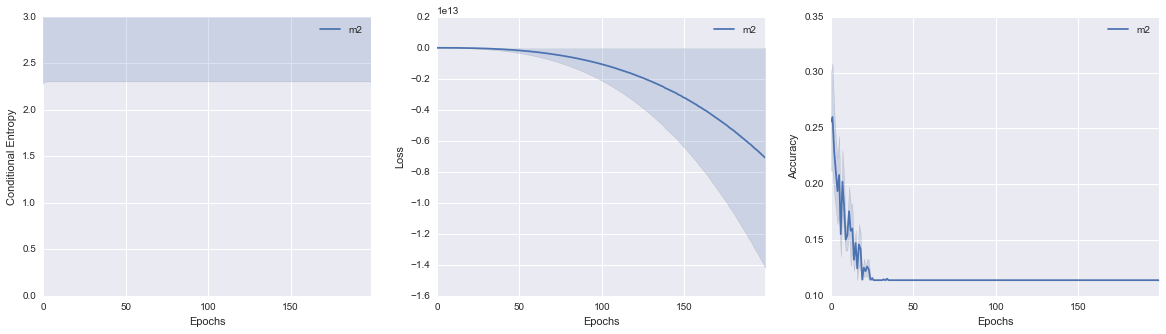

In [62]:
f, axes = plt.subplots(1,3, figsize=(20, 5))
plot_from_csv('m2', axes, 0)
plt.savefig('images/m2.png')

/Users/huxiaojing/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  if sys.path[0] == '':


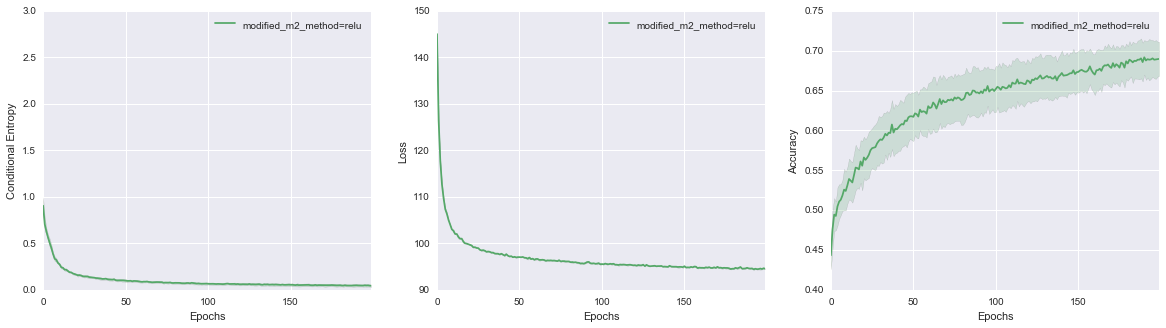

In [63]:
f, axes = plt.subplots(1,3, figsize=(20, 5))
plot_from_csv('modified_m2_method=relu', axes, 1)
plt.savefig('images/modified_m2_method=relu.png')

/Users/huxiaojing/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  if sys.path[0] == '':


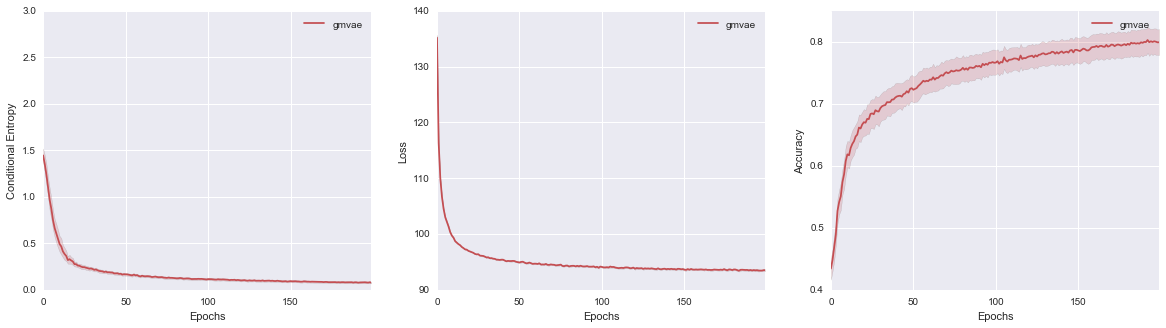

In [64]:
f, axes = plt.subplots(1,3, figsize=(20, 5))
plot_from_csv('gmvae', axes, 2)
plt.savefig('images/gmvae.png')

/Users/huxiaojing/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  if sys.path[0] == '':


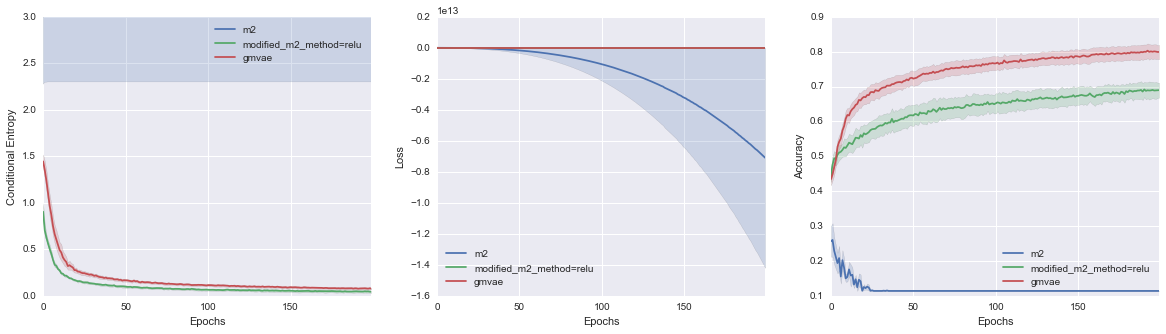

In [65]:
f, axes = plt.subplots(1,3, figsize=(20, 5))
plot_from_csv('m2', axes, 0)
plot_from_csv('modified_m2_method=relu', axes, 1)
plot_from_csv('gmvae', axes, 2)
plt.savefig('images/combined.png')